In [156]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt 
from IPython.core.pylabtools import  figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# データの読み込み

In [157]:
count_data_df=pd.read_csv('./dataset/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/Chapter1_Introduction/data/txtdata.csv',header=None)
n_data=len(count_data_df)

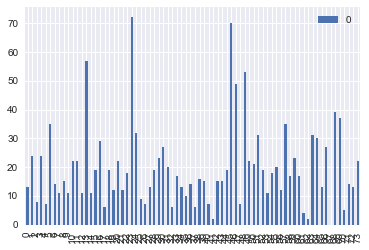

In [158]:
count_data_df.plot.bar()

In [159]:
count_data=count_data_df.T.values[0]

# モデル化

## 事前分布となるモデルを構築

In [160]:
with pm.Model() as model:
    alpha=1.0/count_data.mean()
    
    lambda_1=pm.Exponential('lambda_1',alpha)
    lambda_2=pm.Exponential('lambda_2',alpha)
    
    tau=pm.DiscreteUniform('tau',lower=0,upper=n_count_data-1)

In [161]:
with model:
    idx=np.arange(n_count_data)
    lambda_=pm.math.switch(tau>idx,lambda_1,lambda_2)

## 尤度となるモデルを構築

In [162]:
with model:
    observation=pm.Poisson('obs',lambda_,observed=count_data)

# サンプリング

In [163]:
with model:
    step=pm.Metropolis()
    trace=pm.sample(10000,tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:13<00:00, 4609.09draws/s]
The number of effective samples is smaller than 25% for some parameters.


# 事後分布

In [164]:
lambda_1_smp=trace['lambda_1']
lambda_2_smp=trace['lambda_2']
tau_smp=trace['tau']

/Users/hiroaki/.pyenv/versions/3.6.5/envs/pycoon365/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


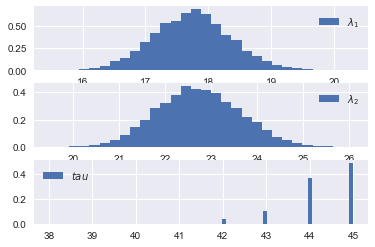

In [165]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,sharex=False)

ax1.hist(x=lambda_1_smp,bins=30,label='$\lambda_1$',normed=True,histtype='stepfilled')
ax1.legend()
ax2.hist(x=lambda_2_smp,bins=30,label='$\lambda_2$',normed=True,histtype='stepfilled')
ax2.legend()

w=1/tau_smp.shape[0]*np.ones_like(tau_smp) # 正規化のための係数
ax3.hist(weights=w,x=tau_smp,bins=n_count_data,label='$tau$')
# ax3.set_xlim([0,count_data])
ax3.legend()



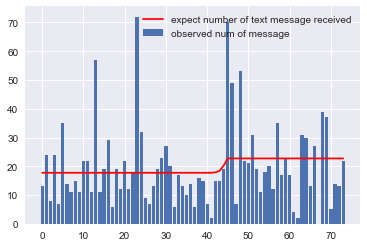

In [173]:
N=tau_smp.shape[0] # Nはsamplingの数(=仮想世界の数)
expect_text_per_day=np.zeros(n_count_data)

for day in range(n_count_data):
    ix=day<tau_smp # 対象の日にちがsamplingしたtauより大きい場合のみを抽出するBoolean
    expect_text_per_day[day]=(lambda_1_smp[ix].sum()+lambda_2_smp[~ix].sum())/N
    
fig,ax=plt.subplots()
ax.bar(np.arange(n_count_data),count_data,label='observed num of message')
ax.plot(np.arange(n_count_data),expect_text_per_day,color='r',label='expect number of text message received')
ax.legend()
